In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from iobs.layers import IOBLayer
from iobs.models import BaseAE
from torch import nn, optim
import os
from sklearn.model_selection import train_test_split

In [101]:
def plot_dynamic_spectra(dynamic_spectra, title="Dynamic Spectra"):
    """
    Plot a dynamic spectrum with horizontal time axis and reversed frequency axis.

    Parameters:
        dynamic_spectra (numpy.ndarray): The dynamic spectrum to plot.
        title (str): The title for the plot (default is "Dynamic Spectra").

    Returns:
        None
    """
    # Calculate the time step based on the number of time samples
    num_time_samples = dynamic_spectra.shape[0]
    time_step = 0.0000256  # Default time step in seconds

    # Calculate the extent based on the number of frequency channels
    extent = [0, num_time_samples * time_step * 1000, 1208, 1700]

    plt.figure(figsize=(10, 6))
    plt.imshow(dynamic_spectra.T, aspect="auto", cmap="viridis", extent=extent)
    plt.xlabel("Time (ms)", size=14)
    plt.ylabel("Frequency (MHz)", size=14)
    plt.colorbar()
    plt.title(title, size=16)
    plt.show()

In [102]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

In [105]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Define the directories containing the data for different classes
directories = [
    "1000_Constant_SNR_simple_narrow",
    "1000_Constant_SNR_simple_broad",
    "1000_Constant_SNR_simulated_scattered",
    "1000_Constant_SNR_complex",
    "1000_Constant_SNR_drifting",
]

# Define the directories containing the data for different classes
# directories = [
    # "1000_Constant_SNR_simple_narrow_res",
    # "1000_Constant_SNR_simple_broad_res",
    # "1000_Constant_SNR_simulated_scattered_res",
    # "1000_Constant_SNR_complex_res",
    # "1000_Constant_SNR_drifting_res",
# ]

data = []
labels = []

for class_idx, directory in enumerate(directories):
    data_dir = f"data/{directory}"
    data_per_directory = []

    for filename in os.listdir(data_dir):
        if filename.endswith(".npy"):
            dynamic_spectra_w_pulse = np.load(os.path.join(data_dir, filename))
            rebinned_spectrum = rebin(dynamic_spectra_w_pulse, (int(1024/4), int(512/4)))
            if np.any(rebinned_spectrum == 0.0):
                rebinned_spectrum[rebinned_spectrum == 0] = 0.0001
            data_per_directory.append(rebinned_spectrum)
            labels.append(class_idx)

    data_per_directory = np.array(data_per_directory)[:1000]
    data.append(data_per_directory)

# Concatenate the data and labels
data = np.concatenate(data, axis=0)
labels = np.array(labels)

# Split the data into training and testing sets while maintaining class balance
test_size = 0.2
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=test_size, shuffle=True, random_state=42)

In [106]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


## Prep data for Network

In [107]:
# Convert data to PyTorch tensors
data_train_tensor = torch.Tensor(data_train[:, None, :])
data_test_tensor = torch.Tensor(data_test[:, None, :])

# Convert labels to PyTorch tensors
labels_train_tensor = torch.LongTensor(labels_train)
labels_test_tensor = torch.LongTensor(labels_test)

# Create weights for training data
train_weights = np.zeros_like(data_train_tensor)

# Calculate the minimum absolute value for every spectrum and add it to the weights list
for i, spectra in enumerate(data_train_tensor):
    min_abs_value = torch.min(torch.abs(spectra))
    train_weights[i, :, :, :]=(torch.log((torch.abs(spectra) / min_abs_value.item())) + 0.1)

# Convert weights to pytorch tensor
train_weights_tensor = torch.tensor(train_weights)

# Create weights for test data
test_weights = np.zeros_like(data_test_tensor)

# Calculate the minimum absolute value for every spectrum and add it to the weights list
for i, spectra in enumerate(data_test_tensor):
    min_abs_value = torch.min(torch.abs(spectra))
    test_weights[i, :, :, :]=(torch.log((torch.abs(spectra) / min_abs_value.item())) + 0.1)

# Convert weights to pytorch tensor
test_weights_tensor = torch.tensor(test_weights)

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(data_train_tensor, train_weights_tensor, labels_train_tensor)
test_dataset = TensorDataset(data_test_tensor, test_weights_tensor, labels_test_tensor)

batch_size = 16  # Adjust as needed
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Define own loss function

In [108]:
# Define weighted loss function to give more strength to signal
class weighted_MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, inputs, targets, weights):
        return torch.sum(((inputs - targets) ** 2 ) * weights)


## Original Fully Connected AutoEncoder

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# Define the autoencoder architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1), # 1x256x128
            # nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256*128, 1000),
            nn.ReLU(),
            nn.Linear(1000,100),
            nn.ReLU(),
            nn.Linear(100,15),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(15,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100, 256*128),  # Reverse linear operation
            nn.Unflatten(1, (1, 256, 128)),  # Reverse flatten operation
            # nn.ConvTranspose2d(1, 1, kernel_size=3, stride=1, padding=1),
            # nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the autoencoder
conv_autoencoder = ConvAutoencoder().to(device)

# Define the loss function and optimizer
# loss_fn = nn.MSELoss()
loss_fn = weighted_MSELoss()
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=0.0005)

In [13]:
# Training the autoencoder
num_epochs = 1000
for epoch in range(num_epochs):
    for data, weights in train_loader:
        inputs = data.to(device)
        outputs = conv_autoencoder(inputs)
        loss = loss_fn(outputs, inputs, weights.to(device))
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # break

    if epoch % 20 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 10492.0645


KeyboardInterrupt: 

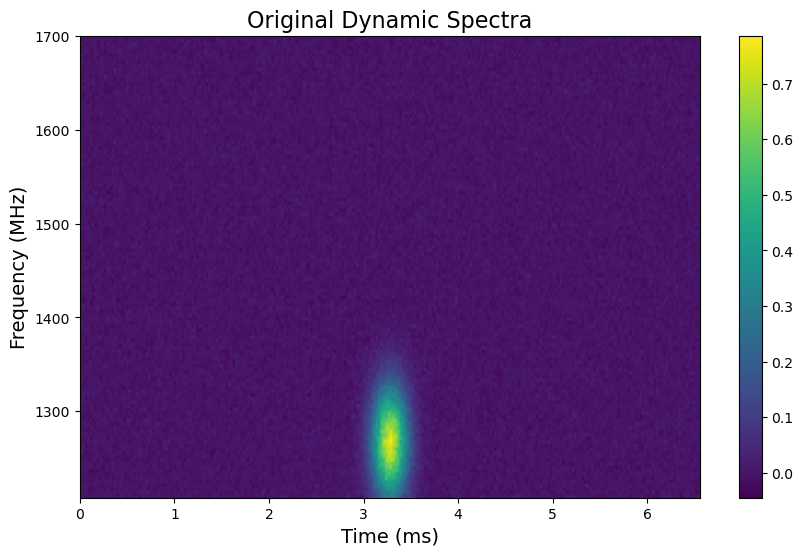

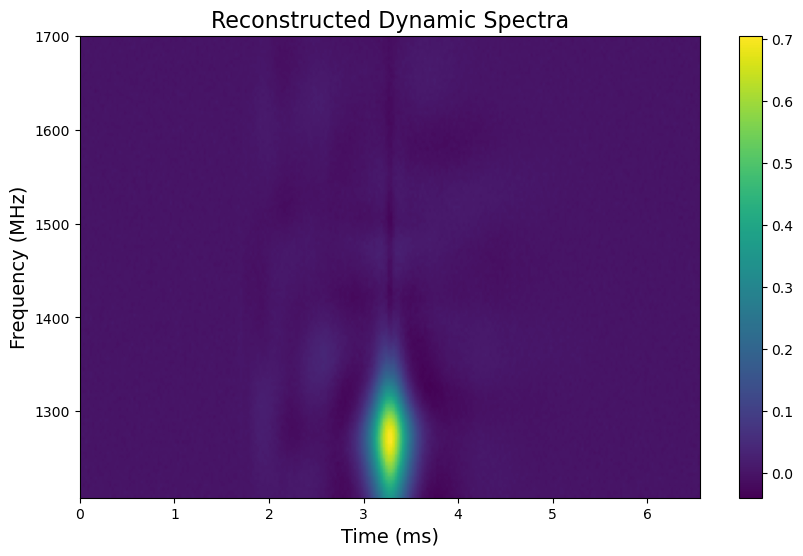

In [56]:
# Testing the autoencoder
conv_autoencoder.eval()
with torch.no_grad():
    inputs = data_train_tensor.to(device)  # Move input data to the GPU
    reconstructed = conv_autoencoder(inputs)
    
idx = 300

# Convert tensors to numpy arrays for plotting
original_np = inputs[idx].cpu().numpy().reshape((int(1024/4), int(512/4)))  # Move data back to CPU for plotting
reconstructed_np = reconstructed[idx].cpu().numpy().reshape((int(1024/4), int(512/4)))  # Move data back to CPU for plotting

# Visualize original and reconstructed data
plot_dynamic_spectra(original_np, title="Original Dynamic Spectra")
plot_dynamic_spectra(reconstructed_np, title="Reconstructed Dynamic Spectra")

## Look at different latent space sizes

In [ ]:
# Define the range of latent space sizes
latent_sizes = range(1, 3)

# Initialize lists to store MSE values and epoch losses
mse_values = []
mse_per_class_values_all = []
epoch_losses_final = []
best_mse = float('inf')
worst_mse = 0

# Store best and worst network
best_network = None
worst_network = None

# Iterate over different latent space sizes
for latent_size in latent_sizes:
    # Initialize list to store MSE values for each run
    run_mse = []
    run_epoch_losses_final = []
    for _ in range(1):  # Perform 10 runs for each latent space size
        # Define the autoencoder architecture with current latent size
        class ConvAutoencoder(nn.Module):
            def __init__(self):
                super(ConvAutoencoder, self).__init__()
                self.encoder = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(256*128, 1000),
                    nn.ReLU(),
                    nn.Linear(1000, 100),
                    nn.ReLU(),
                    nn.Linear(100, latent_size),  # Adjust latent size
                    nn.ReLU()
                )
                self.decoder = nn.Sequential(
                    nn.Linear(latent_size, 100),
                    nn.ReLU(),
                    nn.Linear(100, 100),
                    nn.ReLU(),
                    nn.Linear(100, 256*128),
                    nn.Unflatten(1, (1, 256, 128)),
                )

            def forward(self, x):
                encoded = self.encoder(x)
                decoded = self.decoder(encoded)
                return decoded

        # Initialize the autoencoder
        conv_autoencoder = ConvAutoencoder().to(device)

        # Define the loss function and optimizer
        loss_fn = weighted_MSELoss()
        optimizer = optim.Adam(conv_autoencoder.parameters(), lr=0.0005)

        # Initialize early stopping parameters
        best_loss = float('inf')
        patience = 20
        counter = 0

        # Training the autoencoder
        num_epochs = 1000
        epoch_losses = []
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            for data, weights in train_loader:
                inputs = data.to(device)
                outputs = conv_autoencoder(inputs)
                loss = loss_fn(outputs, inputs, weights.to(device))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item() * inputs.size(0)  # Accumulate the training loss

            if epoch % 50 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
            
            # Calculate average epoch loss
            epoch_loss /= len(train_loader.dataset)
            epoch_losses.append(epoch_loss)

            # Check for early stopping
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                counter = 0  # Reset counter if loss improves
            else:
                counter += 1  # Increment counter if loss doesn't improve
            
            if counter >= patience:
                break

        # Store the MSE between input spectra and reconstructions for the last epoch per burst class
        mse_per_class = []
        with torch.no_grad():
            for class_idx in range(5):  # Assuming num_classes is defined
                class_data = data_test[labels_test == class_idx]
                class_inputs = torch.tensor(class_data).to(device)
                class_outputs = conv_autoencoder(class_inputs)
                class_mse = torch.mean(((class_inputs - class_outputs)**2)).cpu().item()
                mse_per_class.append(class_mse)

        # Store the MSE between input spectra and reconstructions for the last epoch
        with torch.no_grad():
            mse = torch.mean(((inputs - outputs)**2)).cpu().item()  # Move tensor to CPU and calculate MSE
            run_mse.append(mse)

        # Check if the current network has the best or worst MSE
        if mse < best_mse:
            best_mse = mse
            best_network = conv_autoencoder.state_dict()
        if mse > worst_mse:
            worst_mse = mse
            worst_network = conv_autoencoder.state_dict()

        # Store the epoch loss for the final epoch of this run
        run_epoch_losses_final.append(epoch_losses[-1])

    # Store the MSE values and epoch losses for all runs for this latent size
    mse_values.append(run_mse)
    epoch_losses_final.append(run_epoch_losses_final)
    mse_per_class_values_all.append(mse_per_class)

# Plot MSE as a function of latent space size
for idx, mse_list in enumerate(mse_values):
    plt.scatter([latent_sizes[idx]] * len(mse_list), mse_list, label=f'Latent Size: {latent_sizes[idx]}')

plt.title('Mean Squared Error (MSE) vs. Latent Space Size')
plt.xlabel('Latent Space Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Print the epoch losses for the final epoch of each run
for idx, epoch_losses in enumerate(epoch_losses_final):
    print(f"Latent Size: {latent_sizes[idx]}, Final Epoch Losses: {epoch_losses}")

Epoch [1/1000], Loss: 20885.3223
Epoch [51/1000], Loss: 9959.5801
Epoch [101/1000], Loss: 9811.4062
Epoch [151/1000], Loss: 7929.2769
Epoch [201/1000], Loss: 7054.0156
Epoch [251/1000], Loss: 6813.4121
Epoch [301/1000], Loss: 7579.6753
Epoch [1/1000], Loss: 18659.5684
Epoch [51/1000], Loss: 4520.5503
Epoch [101/1000], Loss: 4951.3457
Epoch [151/1000], Loss: 5096.8291
Epoch [201/1000], Loss: 3961.5933
Epoch [251/1000], Loss: 4510.7881
Epoch [301/1000], Loss: 3346.0337
Epoch [351/1000], Loss: 3482.8069


In [18]:
print(epoch_losses_final)
print(mse_per_class_values_all)
print(mse_values)

[[21737.225375]]
[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, 

## Look at different Latent Sizes and Save Models

Epoch [1/1000], Loss: 20871.2422
Epoch [51/1000], Loss: 12939.2402
Epoch [101/1000], Loss: 11469.9258
Epoch [151/1000], Loss: 9638.3066
Epoch [201/1000], Loss: 7689.5166
Epoch [1/1000], Loss: 19730.5547
Epoch [51/1000], Loss: 21998.4629
Epoch [101/1000], Loss: 20459.4883
Epoch [1/1000], Loss: 21354.9922
Epoch [51/1000], Loss: 5479.6387
Epoch [101/1000], Loss: 5240.0186
Epoch [151/1000], Loss: 5182.4434
Epoch [201/1000], Loss: 3332.0769
Epoch [251/1000], Loss: 4493.0933
Epoch [301/1000], Loss: 2985.8223
Epoch [351/1000], Loss: 3679.0188
Epoch [401/1000], Loss: 3234.2009
Epoch [451/1000], Loss: 3272.7068
Epoch [501/1000], Loss: 2400.7490
Epoch [551/1000], Loss: 3891.7273
Epoch [651/1000], Loss: 3367.0591
Epoch [701/1000], Loss: 2834.9729
Epoch [1/1000], Loss: 16614.8633
Epoch [51/1000], Loss: 2893.0254
Epoch [101/1000], Loss: 3115.3074
Epoch [151/1000], Loss: 2169.9497
Epoch [201/1000], Loss: 2225.4075
Epoch [251/1000], Loss: 3493.6746
Epoch [301/1000], Loss: 2811.3701
Epoch [351/1000], 

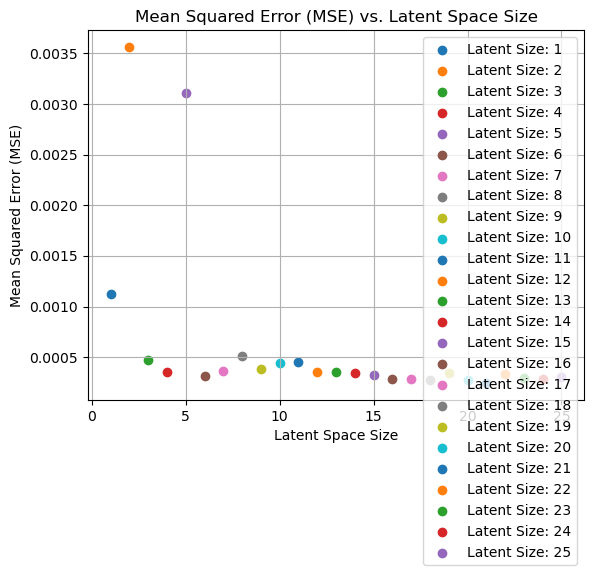

Latent Size: 1, Final Epoch Losses: [8783.1939453125]
Latent Size: 2, Final Epoch Losses: [21737.435203125]
Latent Size: 3, Final Epoch Losses: [3302.5800244140623]
Latent Size: 4, Final Epoch Losses: [2496.814271972656]
Latent Size: 5, Final Epoch Losses: [21737.4797421875]
Latent Size: 6, Final Epoch Losses: [2359.2490112304686]
Latent Size: 7, Final Epoch Losses: [2249.6882934570312]
Latent Size: 8, Final Epoch Losses: [2703.258382324219]
Latent Size: 9, Final Epoch Losses: [2119.644540527344]
Latent Size: 10, Final Epoch Losses: [2220.3262895507814]
Latent Size: 11, Final Epoch Losses: [2291.812859375]
Latent Size: 12, Final Epoch Losses: [2073.5895551757812]
Latent Size: 13, Final Epoch Losses: [2079.8535732421874]
Latent Size: 14, Final Epoch Losses: [2042.780111328125]
Latent Size: 15, Final Epoch Losses: [2010.7125419921874]
Latent Size: 16, Final Epoch Losses: [2024.9840190429688]
Latent Size: 17, Final Epoch Losses: [1970.6989580078125]
Latent Size: 18, Final Epoch Losses: [1

In [109]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the range of latent space sizes
latent_sizes = np.arange(1,26)

# Initialize lists to store MSE values and epoch losses
mse_values = []
epoch_losses_final = []
best_mse = float('inf')
worst_mse = 0

# Store best and worst network
best_network = None
worst_network = None

# Iterate over different latent space sizes
for latent_size in latent_sizes:
    # Initialize list to store MSE values for each run
    run_mse = []
    run_epoch_losses_final = []
    for _ in range(1):  # Perform 10 runs for each latent space size
        # Define the autoencoder architecture with current latent size
        class FullyConnectedAutoencoder(nn.Module):
            def __init__(self):
                super(FullyConnectedAutoencoder, self).__init__()
                self.encoder = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(256*128, 1000),
                    nn.ReLU(),
                    nn.Linear(1000, 100),
                    nn.ReLU(),
                    nn.Linear(100, latent_size),  # Adjust latent size
                    nn.ReLU()
                )
                self.decoder = nn.Sequential(
                    nn.Linear(latent_size, 100),
                    nn.ReLU(),
                    nn.Linear(100, 100),
                    nn.ReLU(),
                    nn.Linear(100, 256*128),
                    nn.Unflatten(1, (1, 256, 128)),
                )

            def forward(self, x):
                encoded = self.encoder(x)
                decoded = self.decoder(encoded)
                return decoded

        # Initialize the autoencoder
        autoencoder = FullyConnectedAutoencoder().to(device)

        # Define the loss function and optimizer
        loss_fn = weighted_MSELoss()
        optimizer = optim.Adam(autoencoder.parameters(), lr=0.0005)

        # Initialize early stopping parameters
        best_loss = float('inf')
        patience = 20
        counter = 0

        # Training the autoencoder
        num_epochs = 1000
        epoch_losses = []
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            for data, weights, _ in train_loader:
                inputs = data.to(device)
                outputs = autoencoder(inputs)
                loss = loss_fn(outputs, inputs, weights.to(device))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item() * inputs.size(0)  # Accumulate the training loss

            if epoch % 50 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
            
            # Calculate average epoch loss
            epoch_loss /= len(train_loader.dataset)
            epoch_losses.append(epoch_loss)

            # Check for early stopping
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                counter = 0  # Reset counter if loss improves
            else:
                counter += 1  # Increment counter if loss doesn't improve
            
            if counter >= patience:
                break

        # Save the trained model along with its architecture information
        torch.save({
            'state_dict': autoencoder.state_dict(),
            'architecture': {
                'encoder_layers': [256 * 128] + [layer.out_features for layer in autoencoder.encoder if isinstance(layer, nn.Linear)],
                'decoder_layers': [layer.out_features for layer in autoencoder.decoder if isinstance(layer, nn.Linear)],
            }
        }, os.path.join('saved_models', f'fully_connected_autoencoder_latent_{latent_size}.pt'))




        # Store the MSE between input spectra and reconstructions for the last epoch
        with torch.no_grad():
            mse = torch.mean(((inputs - outputs)**2)).cpu().item()  # Move tensor to CPU and calculate MSE
            run_mse.append(mse)

        # Check if the current network has the best or worst MSE
        if mse < best_mse:
            best_mse = mse
            best_network = autoencoder.state_dict()
        if mse > worst_mse:
            worst_mse = mse
            worst_network = autoencoder.state_dict()

        # Store the epoch loss for the final epoch of this run
        run_epoch_losses_final.append(epoch_losses[-1])

    # Store the MSE values and epoch losses for all runs for this latent size
    mse_values.append(run_mse)
    epoch_losses_final.append(run_epoch_losses_final)

# Plot MSE as a function of latent space size
for idx, mse_list in enumerate(mse_values):
    plt.scatter([latent_sizes[idx]] * len(mse_list), mse_list, label=f'Latent Size: {latent_sizes[idx]}')

plt.title('Mean Squared Error (MSE) vs. Latent Space Size')
plt.xlabel('Latent Space Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Print the epoch losses for the final epoch of each run
for idx, epoch_losses in enumerate(epoch_losses_final):
    print(f"Latent Size: {latent_sizes[idx]}, Final Epoch Losses: {epoch_losses}")

In [98]:
# Redefine the FullyConnectedAutoencoder class with adjustable latent size to load in trained models
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, latent_size):
        super(FullyConnectedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*128, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, latent_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 256*128),
            nn.Unflatten(1, (1, 256, 128)),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define the desired latent size
latent_size = 20

# Define the model with the desired latent size
autoencoder = FullyConnectedAutoencoder(latent_size).to(device)

# Load the state dictionary
checkpoint = torch.load('saved_models/fully_connected_autoencoder_latent_20.pt')
autoencoder.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

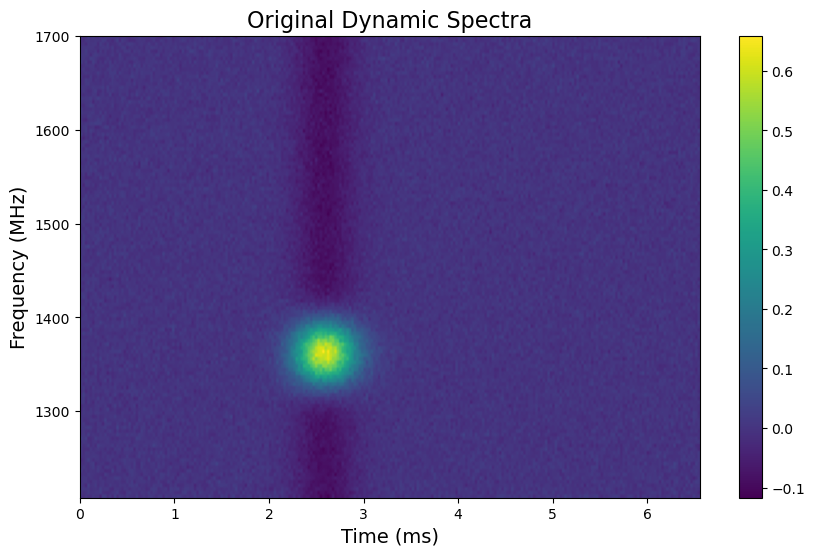

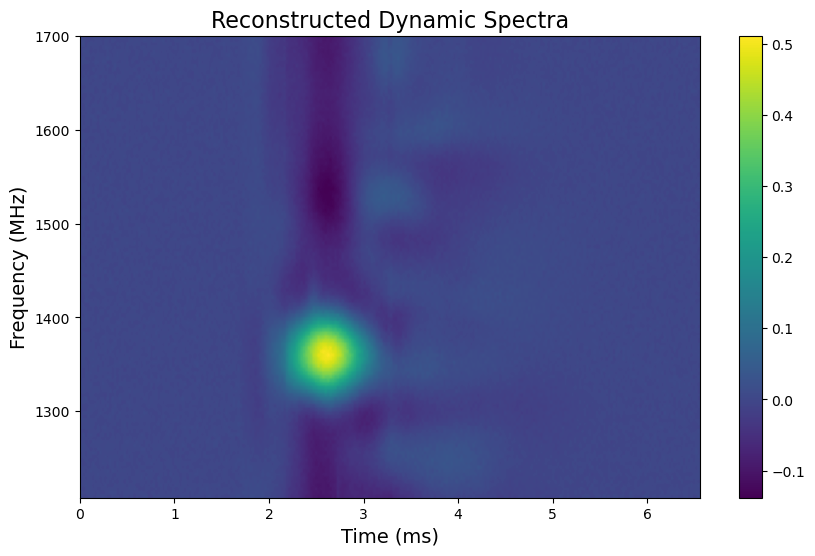

In [99]:
# Reconstruction
with torch.no_grad():
    inputs = data_test_tensor.reshape(-1, 128*256).to(device)  # Move input data to the GPU
    reconstructed = autoencoder(inputs)

# Convert tensors to numpy arrays for plotting
idx = 300  # Example index for visualization
original_np = inputs[idx].cpu().numpy().reshape((int(1024/4), int(512/4)))  # Move data back to CPU for plotting
reconstructed_np = reconstructed[idx].cpu().numpy().reshape((int(1024/4), int(512/4)))  # Move data back to CPU for plotting

# Visualize original and reconstructed data
plot_dynamic_spectra(original_np, title="Original Dynamic Spectra")
plot_dynamic_spectra(reconstructed_np, title="Reconstructed Dynamic Spectra")

## Analyze the saved models

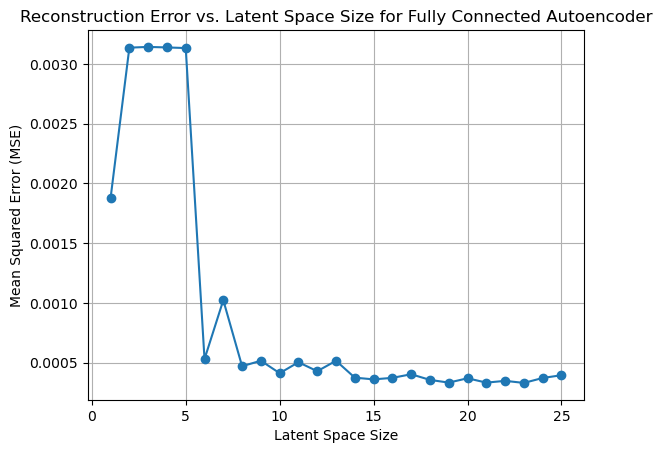

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Redefine the FullyConnectedAutoencoder class with adjustable latent size to load in trained models
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, latent_size):
        super(FullyConnectedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*128, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, latent_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 256*128),
            nn.Unflatten(1, (1, 256, 128)),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define the range of latent space sizes
latent_sizes = np.arange(1, 26)

# Initialize lists to store results
reconstruction_errors_per_latent_size = []
bottleneck_sizes = []

# Testing each model for different latent space sizes
for latent_size in latent_sizes:
    # Load the model for the current latent size
    autoencoder = FullyConnectedAutoencoder(latent_size).to(device)
    checkpoint = torch.load(f'saved_models/fully_connected_autoencoder_latent_{latent_size}.pt')
    autoencoder.load_state_dict(checkpoint['state_dict'])
    autoencoder.eval()

    # Testing the autoencoder
    reconstruction_errors = []
    reconstructed_all = []
    with torch.no_grad():
        for batch_data, _, _ in test_loader:  
            batch_data = batch_data.to(device).reshape(-1, 128 * 256)  
            reconstructed_batch = autoencoder(batch_data).detach().cpu().numpy()  
            reconstructed_all.append(reconstructed_batch)

    reconstructed_all = np.concatenate(reconstructed_all, axis=0)

    # Calculate Mean Squared Error (MSE) for the current latent size
    mse = mean_squared_error(data_test.flatten(), reconstructed_all.flatten())

    # Store reconstruction error (MSE) and latent size
    reconstruction_errors_per_latent_size.append(mse)
    bottleneck_sizes.append(latent_size)

# Plot the reconstruction error (MSE) vs. latent space size
plt.plot(bottleneck_sizes, reconstruction_errors_per_latent_size, marker='o')
plt.xlabel('Latent Space Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Reconstruction Error vs. Latent Space Size for Fully Connected Autoencoder')
plt.grid(True)
plt.show()

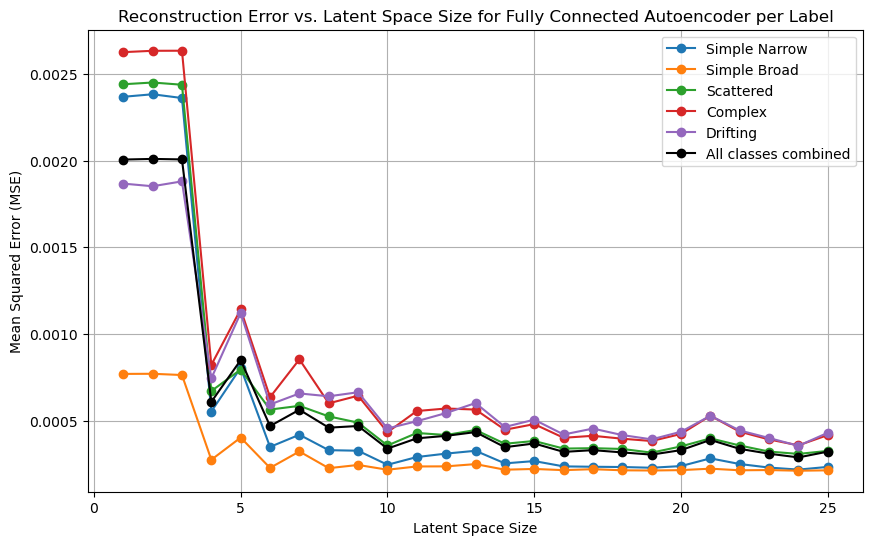

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define labels for each directory
burst_labels = [
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
]

# Redefine the FullyConnectedAutoencoder class with adjustable latent size to load in trained models
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, latent_size):
        super(FullyConnectedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*128, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, latent_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 256*128),
            nn.Unflatten(1, (1, 256, 128)),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define the range of latent space sizes
latent_sizes = np.arange(1, 26)

# Initialize lists to store results
reconstruction_errors_per_label = {label: [] for label in set(labels_test)}
reconstruction_errors = []

# Testing each model for different latent space sizes
for latent_size in latent_sizes:
    # Load the model for the current latent size
    autoencoder = FullyConnectedAutoencoder(latent_size).to(device)
    checkpoint = torch.load(f'saved_models/fully_connected_autoencoder_latent_{latent_size}.pt')
    autoencoder.load_state_dict(checkpoint['state_dict'])
    autoencoder.eval()

    reconstructed_all = []

    with torch.no_grad():
        for batch_data, _, batch_labels in test_loader:  # Extract only batch_data and batch_labels
            batch_data = batch_data.to(device).reshape(-1, 128 * 256)  # Move input data to the GPU and reshape
            reconstructed_batch = autoencoder(batch_data).detach().cpu().numpy()  # Forward the batch through the model
            reconstructed_all.append(reconstructed_batch)

    # Concatenate reconstructed batches
    reconstructed_all = np.concatenate(reconstructed_all, axis=0)

    # Calculate Mean Squared Error (MSE) for the current bottleneck width
    mse_all = mean_squared_error(data_test.flatten(), reconstructed_all.flatten())
    
    # Store reconstruction error (MSE) and bottleneck size
    reconstruction_errors.append(mse_all)
    
    # Iterate over each label
    for label in set(labels_test):
        # Select reconstructed data for the current label
        reconstructed = reconstructed_all[labels_test == label]

        # Calculate Mean Squared Error (MSE) for the current label and latent size
        mse = mean_squared_error(data_test[labels_test == label].flatten(), reconstructed.flatten())

        # Store reconstruction error (MSE) for the current label and latent size
        reconstruction_errors_per_label[label].append(mse)

# Plot the reconstruction error (MSE) vs. latent space size for each label
plt.figure(figsize=(10, 6))
for idx, (label, errors) in enumerate(reconstruction_errors_per_label.items()):
    plt.plot(bottleneck_sizes, errors, marker='o', label=f'{burst_labels[label]}')
    
plt.plot(latent_sizes, reconstruction_errors, marker='o', color='black', label='All classes combined')

plt.xlabel('Latent Space Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Reconstruction Error vs. Latent Space Size for Fully Connected Autoencoder per Label')
plt.legend()
plt.grid(True)
plt.show()



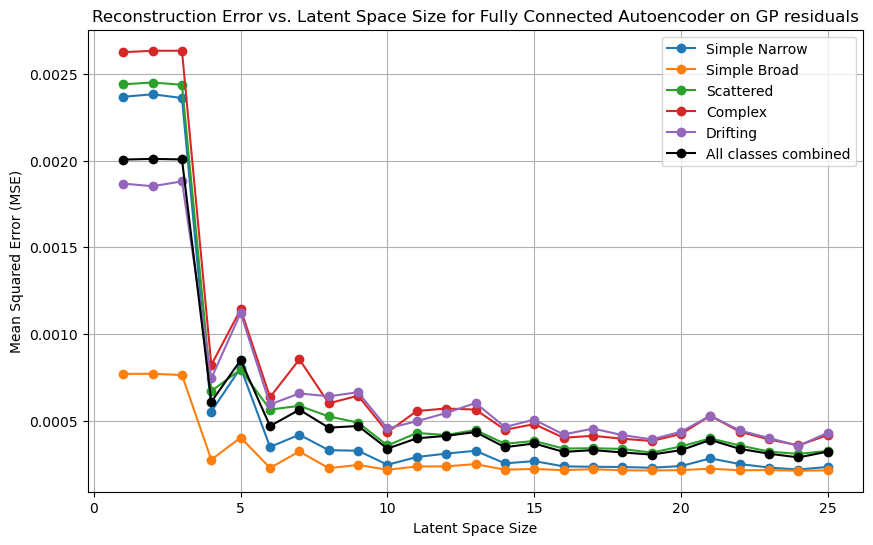

In [94]:
# Plot the reconstruction error (MSE) vs. latent space size for each label
plt.figure(figsize=(10, 6))
for idx, (label, errors) in enumerate(reconstruction_errors_per_label.items()):
    plt.plot(bottleneck_sizes, errors, marker='o', label=f'{burst_labels[label]}')
    
plt.plot(latent_sizes, reconstruction_errors, marker='o', color='black', label='All classes combined')

plt.xlabel('Latent Space Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Reconstruction Error vs. Latent Space Size for Fully Connected Autoencoder on GP residuals')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the Encoder class
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*128, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, latent_size),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

# Load the saved model
latent_size = 5  # Adjust latent size accordingly
model_path = 'saved_models/fully_connected_autoencoder_latent_5.pt'  # Path to the saved model
saved_model = torch.load(model_path)

# Initialize the encoder
encoder = Encoder(latent_size)

# Load only the encoder parameters from the saved state_dict
encoder_state_dict = {k.replace('encoder.', ''): v for k, v in saved_model['state_dict'].items() if 'encoder' in k}
encoder.load_state_dict(encoder_state_dict)

# Set the model to evaluation mode
encoder.eval()

# Pass the input data through the encoder to obtain the encoded representations
encoded_representations = []
with torch.no_grad():
    for batch_data, _, _ in test_loader:
        batch_data = batch_data.to(device)
        encoded = encoder(batch_data)
        encoded_representations.append(encoded.cpu().numpy())

# Concatenate encoded representations from all batches
encoded_representations = np.concatenate(encoded_representations, axis=0)

# Visualize the latent space
plt.scatter(encoded_representations[:, 0], encoded_representations[:, 1])
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Space Visualization')
plt.grid(True)
plt.show()


RuntimeError: Error(s) in loading state_dict for Encoder:
	Missing key(s) in state_dict: "encoder.1.weight", "encoder.1.bias", "encoder.3.weight", "encoder.3.bias", "encoder.5.weight", "encoder.5.bias". 
	Unexpected key(s) in state_dict: "1.weight", "1.bias", "3.weight", "3.bias", "5.weight", "5.bias". 

ValueError: 'x' and 'y' must have the same size

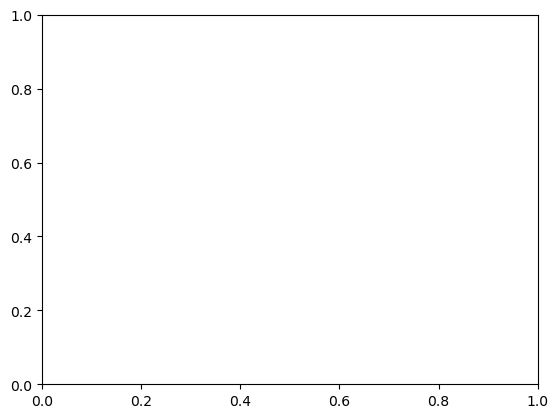

In [23]:
# Extract means and standard deviations for plotting
mean_mse = [mse[0] for mse in mse_values]
std_mse = [mse[1] for mse in mse_values]

# Plot MSE as a function of latent space size with error bars
plt.errorbar(latent_sizes, mean_mse, yerr=std_mse, fmt='o', linestyle='-', color='b', capsize=5, markersize=5, markeredgewidth=2)
plt.title('Mean Squared Error (MSE) vs. Latent Space Size')
plt.xlabel('Latent Space Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

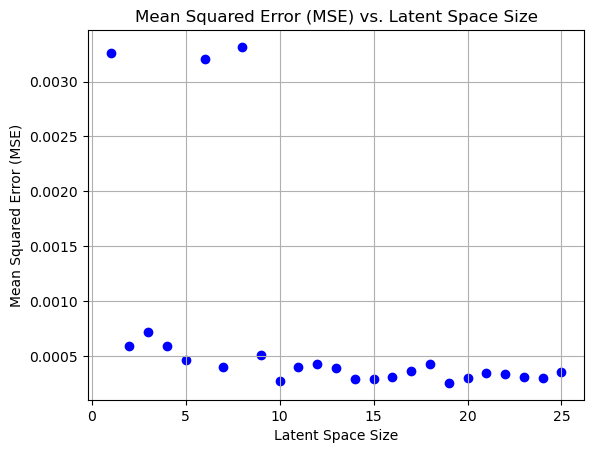

In [56]:
# Plot MSE as a function of latent space size
for idx, mse_list in enumerate(mse_values):
    plt.scatter([latent_sizes[idx]] * len(mse_list), mse_list, c='b')

plt.title('Mean Squared Error (MSE) vs. Latent Space Size')
plt.xlabel('Latent Space Size')
plt.ylabel('Mean Squared Error (MSE)')
# plt.legend()
plt.grid(True)
plt.show()

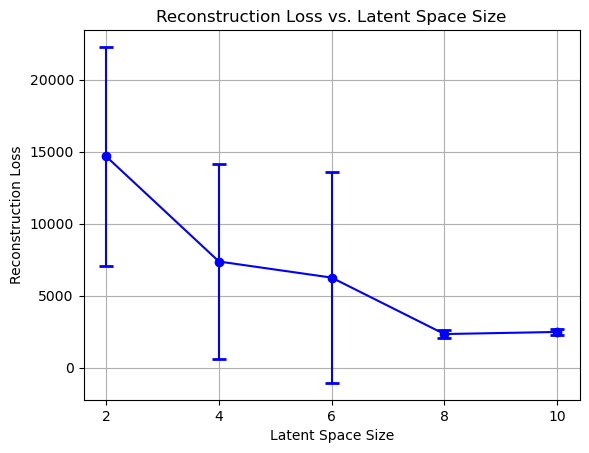

In [263]:
# Extract means and standard deviations for plotting
mean_losses = [loss[0] for loss in losses]
std_losses = [loss[1] for loss in losses]

# Plot reconstruction loss as a function of latent space size with error bars
plt.errorbar(latent_sizes, mean_losses, yerr=std_losses, fmt='o', linestyle='-', color='b', capsize=5, markersize=5, markeredgewidth=2)
plt.title('Reconstruction Loss vs. Latent Space Size')
plt.xlabel('Latent Space Size')
plt.ylabel('Reconstruction Loss')
plt.grid(True)
plt.xticks(latent_sizes)
# plt.yscale('log')  # Plot on logarithmic scale for better visualization
plt.show()

## Explore the latent space

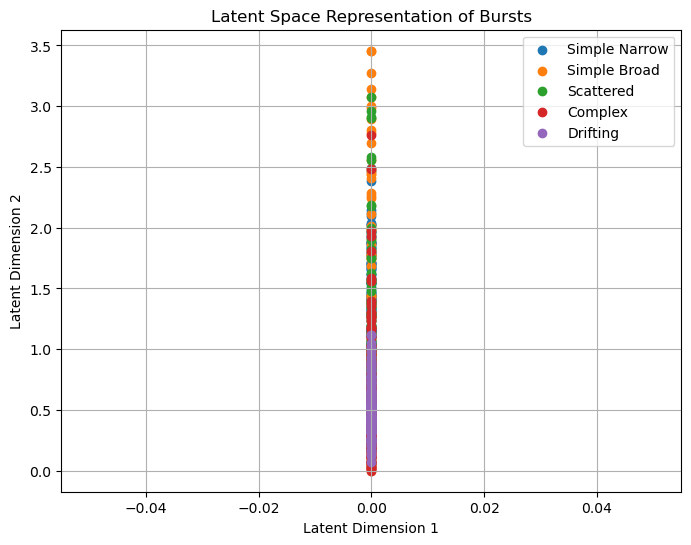

In [419]:
# Define custom labels for burst categories
burst_categories = [
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
]

# Initialize lists to store burst categories and encoded bursts
encoded_bursts = []

# Encode burst data using the trained autoencoder
for data, _ in test_loader:
    with torch.no_grad():
        outputs = conv_autoencoder.encoder(data)
        encoded_bursts.append(outputs.numpy())

print(test_loader)


# Concatenate the encoded bursts
encoded_bursts = np.concatenate(encoded_bursts, axis=0)

# Extract the first two latent dimensions
latent_dim1 = encoded_bursts[:, 0]
latent_dim2 = encoded_bursts[:, 1]

# Plot the latent space representation with custom colors and labels for each burst category
plt.figure(figsize=(8, 6))
for i, category in enumerate(burst_categories):
    idx = labels_test == i
    plt.scatter(latent_dim1[idx], latent_dim2[idx], marker='o', label=category)

plt.title('Latent Space Representation of Bursts')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.grid(True)
plt.show()


In [71]:
# Initialize lists to store burst categories and encoded bursts
encoded_bursts = []

# Encode burst data using the trained autoencoder
for data, _ in test_loader:
    with torch.no_grad():
        outputs = conv_autoencoder.encoder(data)
        encoded_bursts.append(outputs.numpy())

# Concatenate the encoded bursts
encoded_bursts = np.concatenate(encoded_bursts, axis=0)

# Create labels for each component
labels = [f"Latent Dimension {i+1}" for i in range(8)]

burst_labels = [
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
]

# Create a square grid of subplots
fig, axes = plt.subplots(8, 8, figsize=(30, 30))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Plot histograms on the diagonal
for i in range(8):
    axes[i, i].hist(encoded_bursts[:, i], bins=30, color='blue', alpha=0.7)
    if i == 0:
        axes[i, i].set_ylabel('Counts')
    if i == 7:
        axes[i, i].set_xlabel(labels[i])
        axes[i, i].tick_params(axis='x', bottom=True, top=False)
    else:
        axes[i, i].tick_params(axis='x', bottom=False, top=False, labelbottom=False)

# Plot scatter plots on the off-diagonal
for i in range(8):
    for j in range(i + 1, 8):
        for k, label in enumerate(burst_labels):
            num_samples = data[k].shape[0]
            start_idx = sum(len(data[m]) for m in range(k))
            end_idx = start_idx + num_samples
            axes[i, j].set_axis_off()
            idx = labels_test == k
            axes[j, i].scatter(encoded_bursts[idx, i], encoded_bursts[idx, j], label=label, s=5)
        if i == 0:
            axes[j, i].set_ylabel(labels[j])
            axes[j, i].tick_params(axis='y', left=True, right=False)
        else:
            axes[j, i].tick_params(axis='y', left=False, right=False, labelleft=False)

        # Adjust y-axis labels and ticks
        if j == 7:
            axes[j, i].set_xlabel(labels[i])
            axes[j, i].tick_params(axis='x', bottom=True, top=False)
        else:
            axes[j, i].tick_params(axis='x', bottom=False, top=False, labelbottom=False)

# Add legend outside the subplots
fig.legend([
    "Counts",
    "Simple Broad",
    "Simple Narrow",
    "Scattered",
    "Complex",
    "Drifting"
], loc='upper left', bbox_to_anchor=(0.45, 0.8), fontsize='30')

# Adjust layout for better visualization
plt.tight_layout()

plt.suptitle("Cornerplot of 8 Latent Dimensions")

# Show the plot
plt.show()




RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)

In [421]:
# Check the values of latent dimensions 1, 3, and 7
latent_dim1_values = encoded_bursts[:, 0]
latent_dim3_values = encoded_bursts[:, 2]
latent_dim7_values = encoded_bursts[:, 6]

print("Latent Dimension 1 values:", latent_dim1_values)
print("Latent Dimension 3 values:", latent_dim3_values)
print("Latent Dimension 7 values:", latent_dim7_values)


Latent Dimension 1 values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.

## Explore MSE per burst category

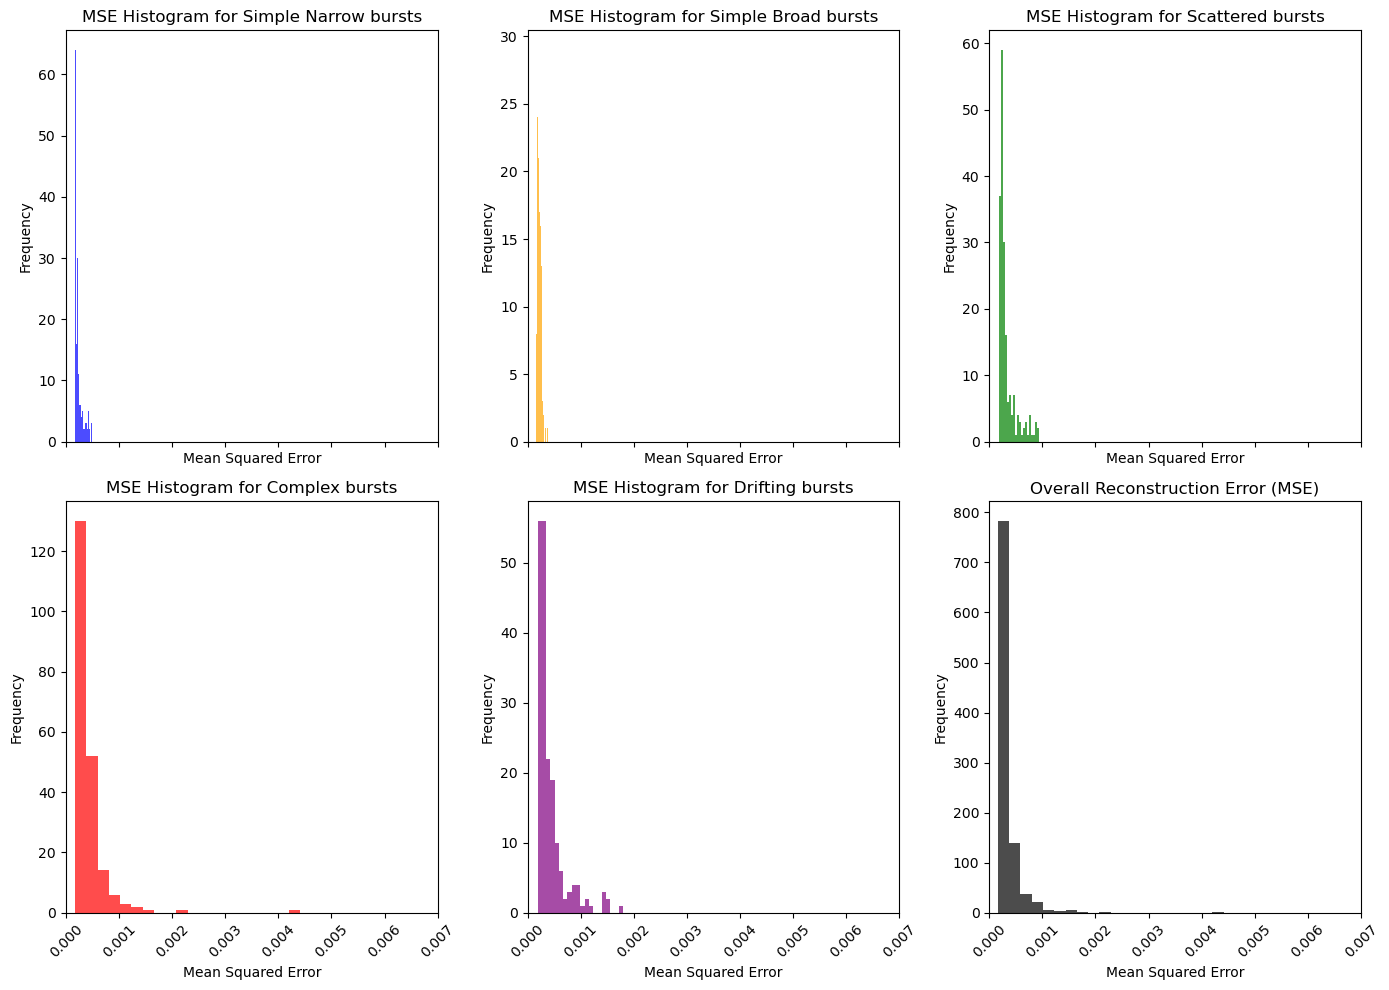

In [73]:
from sklearn.metrics import mean_squared_error

# Calculate the mean square error for each burst and each class
mse_all_autoencoder = []

# Calculate overall mean square error for autoencoder reconstructions
for original_burst in data_test:
    # Convert to tensor and move to device
    original_burst_tensor = torch.tensor(original_burst).unsqueeze(0).to(device)

    # Encode and decode
    with torch.no_grad():
        reconstructed_burst = conv_autoencoder(original_burst_tensor).squeeze().cpu().numpy()

    mse = mean_squared_error(original_burst.flatten(), reconstructed_burst.flatten())
    mse_all_autoencoder.append(mse)

# Define colors for each label
colors = ['blue', 'orange', 'green', 'red', 'purple']

burst_labels = [
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
]

# Set the figure size
fig, axes = plt.subplots(2, 3 ,figsize=(14, 10), sharex=True)
axes = np.hstack(axes)
axes[0].set_xlim(0, 0.007)

# Create subplots for each directory
for i, label in enumerate(burst_labels):
    num_samples = np.sum(labels_test == i)  # Count the number of samples for this label

    # Extract the MSE values for the current directory
    mse_directory_autoencoder = np.array(mse_all_autoencoder)[np.array(labels_test) == i]

    # Create subplots with colored histograms
    axes[i].hist(mse_directory_autoencoder, bins=20, color=colors[i], alpha=0.7)
    axes[i].set_title(f'MSE Histogram for {label} bursts')
    axes[i].set_xlabel('Mean Squared Error')
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate the x-axis tick labels by 45 degrees

# Calculate overall mean square error for autoencoder reconstructions
mse_all_autoencoder = np.array(mse_all_autoencoder)
axes[-1].hist(mse_all_autoencoder, bins=20, color='black', alpha=0.7)
axes[-1].set_title('Overall Reconstruction Error (MSE)')
axes[-1].set_xlabel('Mean Squared Error')
axes[-1].set_ylabel('Frequency')
axes[-1].tick_params(axis='x', rotation=45)  # Rotate the x-axis tick labels by 45 degrees

# Adjust layout for better visualization
plt.tight_layout()
# plt.suptitle('AutoEncoder Reconstruction Error histogram')

# Show the plot
plt.show()


## Original, Reconstruction & Error plot

In [55]:
from sklearn.metrics import mean_squared_error

# Calculate the mean square error for each burst in the test set
mse_all = []

for original_burst in data_test:
    original_tensor = torch.tensor(original_burst).unsqueeze(0)  # Add batch dimension
    reconstructed_tensor = conv_autoencoder(original_tensor)
    reconstructed_np = reconstructed_tensor.detach().numpy().reshape((256, 128))  # Adjusted for rebinned dimensions
    mse = mean_squared_error(original_burst.flatten(), reconstructed_np.flatten())
    mse_all.append(mse)

# Sort the indices of bursts based on MSE in descending order
sorted_indices = np.argsort(mse_all)[::-1]

# Plot the reconstructions for the bursts with the highest MSE
num_bursts_to_plot = 5  # Number of bursts to plot
fig, axs = plt.subplots(num_bursts_to_plot, 3, figsize=(15, num_bursts_to_plot * 5))

for i in range(num_bursts_to_plot):
    idx = sorted_indices[i]
    original_np = data_test[idx].reshape((256, 128))  # Adjusted for rebinned dimensions
    original_tensor = torch.tensor(data_test[idx]).unsqueeze(0)  # Add batch dimension
    reconstructed_tensor = conv_autoencoder(original_tensor)
    reconstructed_np = reconstructed_tensor.detach().numpy().reshape((256, 128))  # Adjusted for rebinned dimensions
    difference_np = original_np - reconstructed_np

    # Calculate the time step based on the number of time samples
    num_time_samples = original_np.shape[0]
    time_step = 0.0000256 * 4  # Adjusted for rebinned time steps

    # Calculate the extent based on the number of frequency channels
    extent = [0, num_time_samples * time_step * 1000, 1700, 1208]

    # Original Dynamic Spectrum
    im1 = axs[i, 0].imshow(original_np.T, aspect="auto", cmap='viridis', extent=extent)
    axs[i, 0].set_title(f"Original Dynamic Spectra (MSE: {mse_all[idx]:.4f})")
    axs[i, 0].set_xlabel("Time (ms)", size=14)
    axs[i, 0].set_ylabel("Frequency (MHz)", size=14)
    plt.colorbar(im1, ax=axs[i, 0], label="Intensity")

    # Reconstructed Dynamic Spectrum
    im2 = axs[i, 1].imshow(reconstructed_np.T, aspect="auto", cmap='viridis', extent=extent)
    axs[i, 1].set_title("Reconstructed Dynamic Spectra")
    axs[i, 1].set_xlabel("Time (ms)", size=14)
    plt.colorbar(im2, ax=axs[i, 1], label="Intensity")

    # Difference/Error
    im3 = axs[i, 2].imshow(difference_np.T, aspect="auto", cmap='viridis', extent=extent)
    axs[i, 2].set_title("Difference/Error")
    axs[i, 2].set_xlabel("Time (ms)", size=14)
    plt.colorbar(im3, ax=axs[i, 2], label="Difference")

plt.tight_layout()
plt.show()



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)

[[-1.62869692e-05 -1.05104846e-07 -9.83849168e-06 ... -5.39794564e-06
  -6.15743920e-06 -3.08528543e-05]
 [-1.44140255e-11 -4.95570252e-12 -3.90656889e-18 ... -1.96401629e-20
  -5.18734361e-14 -3.68501684e-18]
 [-1.85682438e-06 -6.24368113e-09 -4.34555113e-06 ... -5.39049506e-06
  -2.34972686e-06 -2.01612711e-05]
 ...
 [-3.91722210e-11 -7.29976080e-11 -2.95952499e-14 ... -1.95568646e-08
  -6.24597305e-07 -8.39427230e-08]
 [-5.45941293e-06 -1.92485750e-05 -1.67172402e-05 ...  2.04443932e-05
  -4.09781933e-05 -4.61935997e-06]
 [-9.40781320e-08 -1.51190907e-05 -4.92900654e-09 ... -3.18442471e-06
  -2.04965472e-05 -2.49110162e-05]]


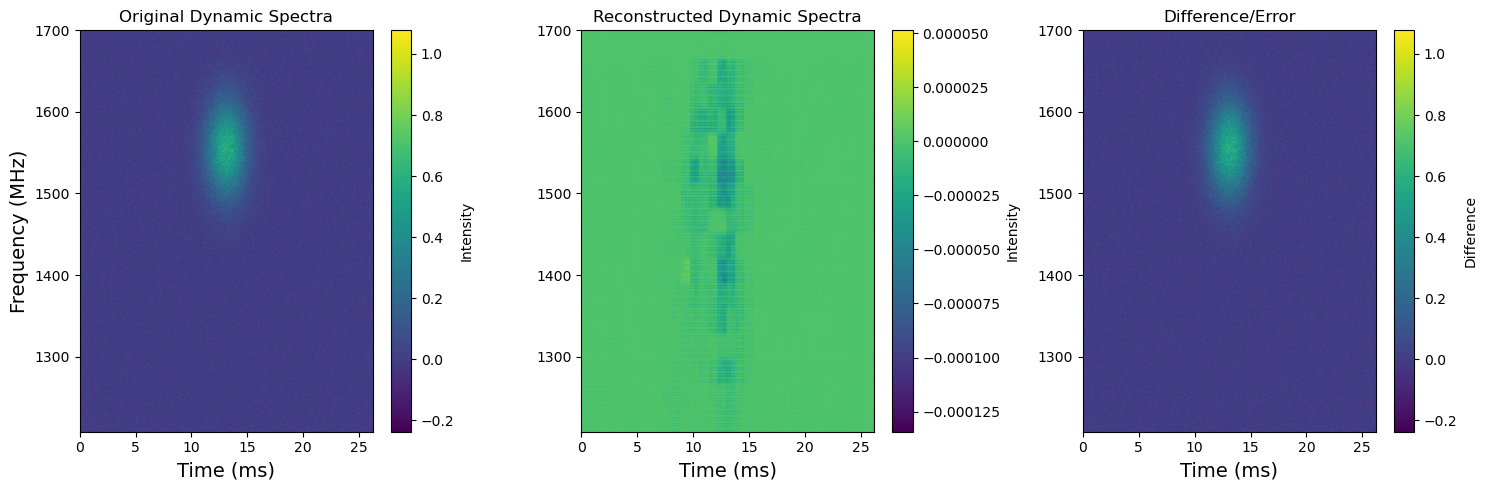

In [219]:
# Convert tensors to numpy arrays for plotting
original_np = inputs[1].numpy().reshape((1024, 512))
reconstructed_np = reconstructed[2].numpy().reshape((1024, 512)) - reconstructed[1].numpy().reshape((1024, 512)) 

# Calculate the difference/error
difference_np = original_np - reconstructed_np

print(reconstructed_np)

# Calculate the time step based on the number of time samples
num_time_samples = original_np.shape[0]
time_step = 0.0000256  # Default time step in seconds

# Calculate the extent based on the number of frequency channels
extent = [0, num_time_samples * time_step * 1000, 1208, 1700]

# Original Dynamic Spectrum
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im1 = axs[0].imshow(original_np.T, aspect="auto", cmap='viridis', origin='lower', extent=extent)
axs[0].set_title("Original Dynamic Spectra")
axs[0].set_xlabel("Time (ms)", size=14)
axs[0].set_ylabel("Frequency (MHz)", size=14)
plt.colorbar(im1, ax=axs[0], label="Intensity")

# Reconstructed Dynamic Spectrum
im2 = axs[1].imshow(reconstructed_np.T, aspect="auto", cmap='viridis', origin='lower', extent=extent)
axs[1].set_title("Reconstructed Dynamic Spectra")
axs[1].set_xlabel("Time (ms)", size=14)
plt.colorbar(im2, ax=axs[1], label="Intensity")

# Difference/Error
im3 = axs[2].imshow(difference_np.T, aspect="auto", cmap='viridis', origin='lower', extent=extent)
axs[2].set_title("Difference/Error")
axs[2].set_xlabel("Time (ms)", size=14)
plt.colorbar(im3, ax=axs[2], label="Difference")

plt.tight_layout()
plt.show()

In [68]:
from torchviz import make_dot

# Initialize the autoencoder
conv_autoencoder = ConvAutoencoder()

# Visualize the network
x = torch.randn(1, 1, 1024, 512)  # Example input
y = conv_autoencoder(x)

# Use make_dot to create the graph visualization
graph = make_dot(y, params=dict(conv_autoencoder.named_parameters()))

# Save the graph as a PDF file
graph.render("conv_autoencoder_graph")

# Display the graph
graph.view()

'conv_autoencoder_graph.pdf'

## With maxpooling


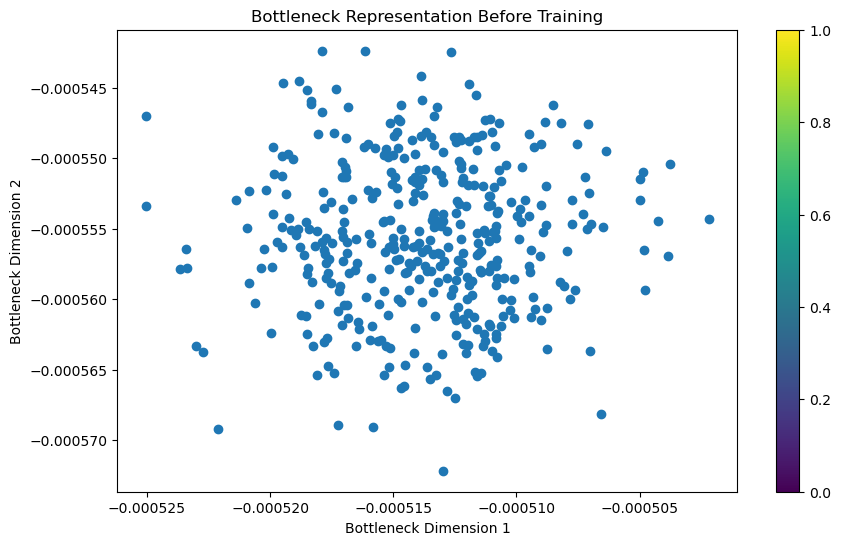

Epoch [1/20], Loss: 0.0057
Epoch [2/20], Loss: 0.0063
Epoch [3/20], Loss: 0.0059
Epoch [4/20], Loss: 0.0059
Epoch [5/20], Loss: 0.0066
Epoch [6/20], Loss: 0.0058
Epoch [7/20], Loss: 0.0053
Epoch [8/20], Loss: 0.0066
Epoch [9/20], Loss: 0.0063
Epoch [10/20], Loss: 0.0063
Epoch [11/20], Loss: 0.0064
Epoch [12/20], Loss: 0.0061
Epoch [13/20], Loss: 0.0059
Epoch [14/20], Loss: 0.0061
Epoch [15/20], Loss: 0.0057
Epoch [16/20], Loss: 0.0064
Epoch [17/20], Loss: 0.0061
Epoch [18/20], Loss: 0.0057
Epoch [19/20], Loss: 0.0066
Epoch [20/20], Loss: 0.0054


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Define the autoencoder architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),  # 8x512x256
            nn.LeakyReLU(),
            nn.Conv2d(8, 8, kernel_size=3, stride=2, padding=1),  # 8x256x128
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),  # 16x128x64
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),  # 16x64x32
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),  # 16x32x16
            nn.LeakyReLU(),
            nn.Flatten(),
            # nn.Linear(8192, 20),
            # nn.LeakyReLU()
        )

        self.decoder = nn.Sequential(
            # nn.Linear(20, 8192),  # Reverse linear operation
            nn.Unflatten(1, (16, 32, 16)),  # Reverse flatten operation
            # nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2, output_padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2, output_padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded  # Now returns both decoded and encoded

# Convert data to PyTorch tensors
data_train_tensor = torch.Tensor(data_train[:, None, :])

# Initialize the autoencoder
conv_autoencoder = ConvAutoencoder()

# Get the bottleneck representation before training
conv_autoencoder.eval()
with torch.no_grad():
    encoded_representation = conv_autoencoder(data_train_tensor)[1]  # Take the second output (encoded)

# Plot the bottleneck representation
plt.figure(figsize=(10, 6))
plt.scatter(encoded_representation[:, 0], encoded_representation[:, 1])
plt.title('Bottleneck Representation Before Training')
plt.xlabel('Bottleneck Dimension 1')
plt.ylabel('Bottleneck Dimension 2')
plt.colorbar()
plt.show()

# Convert data to PyTorch tensors
data_train_tensor = torch.Tensor(data_train[:, None, :])
data_test_tensor = torch.Tensor(data_test[:, None, :])

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(data_train_tensor, torch.LongTensor(labels_train))
test_dataset = TensorDataset(data_test_tensor, torch.LongTensor(labels_test))

batch_size = 16  # Adjust as needed
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the loss function and optimizer with weight decay
weight_decay = 1e-5  # Adjust as needed
loss_fn = nn.MSELoss()
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=0.001, weight_decay=weight_decay)

# Training the autoencoder
num_epochs = 20  # Increased the number of epochs
for epoch in range(num_epochs):
    for data, _ in train_loader:
        inputs = data
        outputs, _ = conv_autoencoder(inputs)  # Updated to get both decoded and encoded
        loss = loss_fn(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


# Testing the autoencoder
# conv_autoencoder.eval()
# test_loss = 0.0  # Initialize test loss

# with torch.no_grad():
#     for data, _ in test_loader:
#         inputs = data
#         outputs = conv_autoencoder(inputs)
        
#         # Compute the test loss for the current batch
#         batch_loss = loss_fn(outputs, inputs).item()
#         test_loss += batch_loss

#         # Print the test loss for the current batch
#         print(f'Test Loss (Batch): {batch_loss:.4f}')

# # Calculate and print the average test loss
# average_test_loss = test_loss / len(test_loader.dataset)
# print(f'Average Test Loss: {average_test_loss:.4f}')


torch.Size([100, 8192])


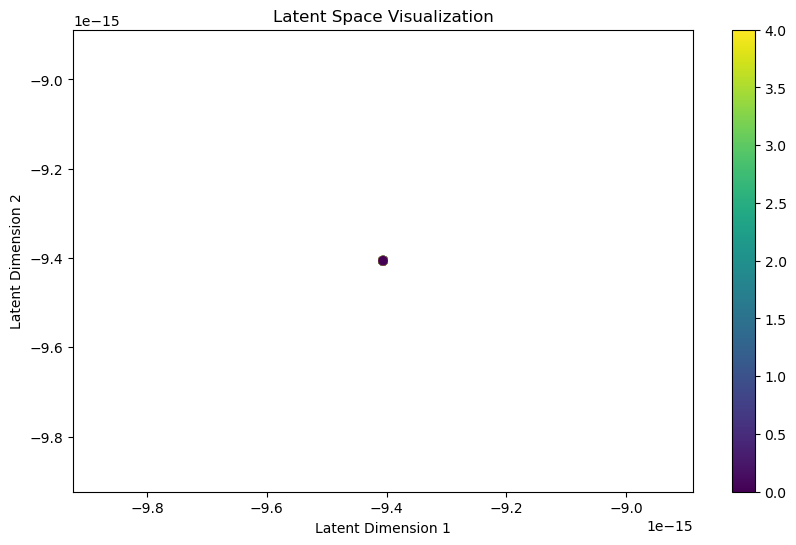

In [9]:
# Testing the autoencoder
conv_autoencoder.eval()
with torch.no_grad():
    latent_activations = []  # To store latent space activations
    for data, _ in test_loader:
        inputs = data
        encoded = conv_autoencoder(inputs)[1]
        latent_activations.append(encoded)


# Concatenate all activations
latent_activations = torch.cat(latent_activations, dim=0)

print(latent_activations.shape)

# Visualize the latent space
plt.figure(figsize=(10, 6))
plt.scatter(latent_activations[:, 0], latent_activations[:, 1], c=labels_test, cmap='viridis')
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar()
plt.show()

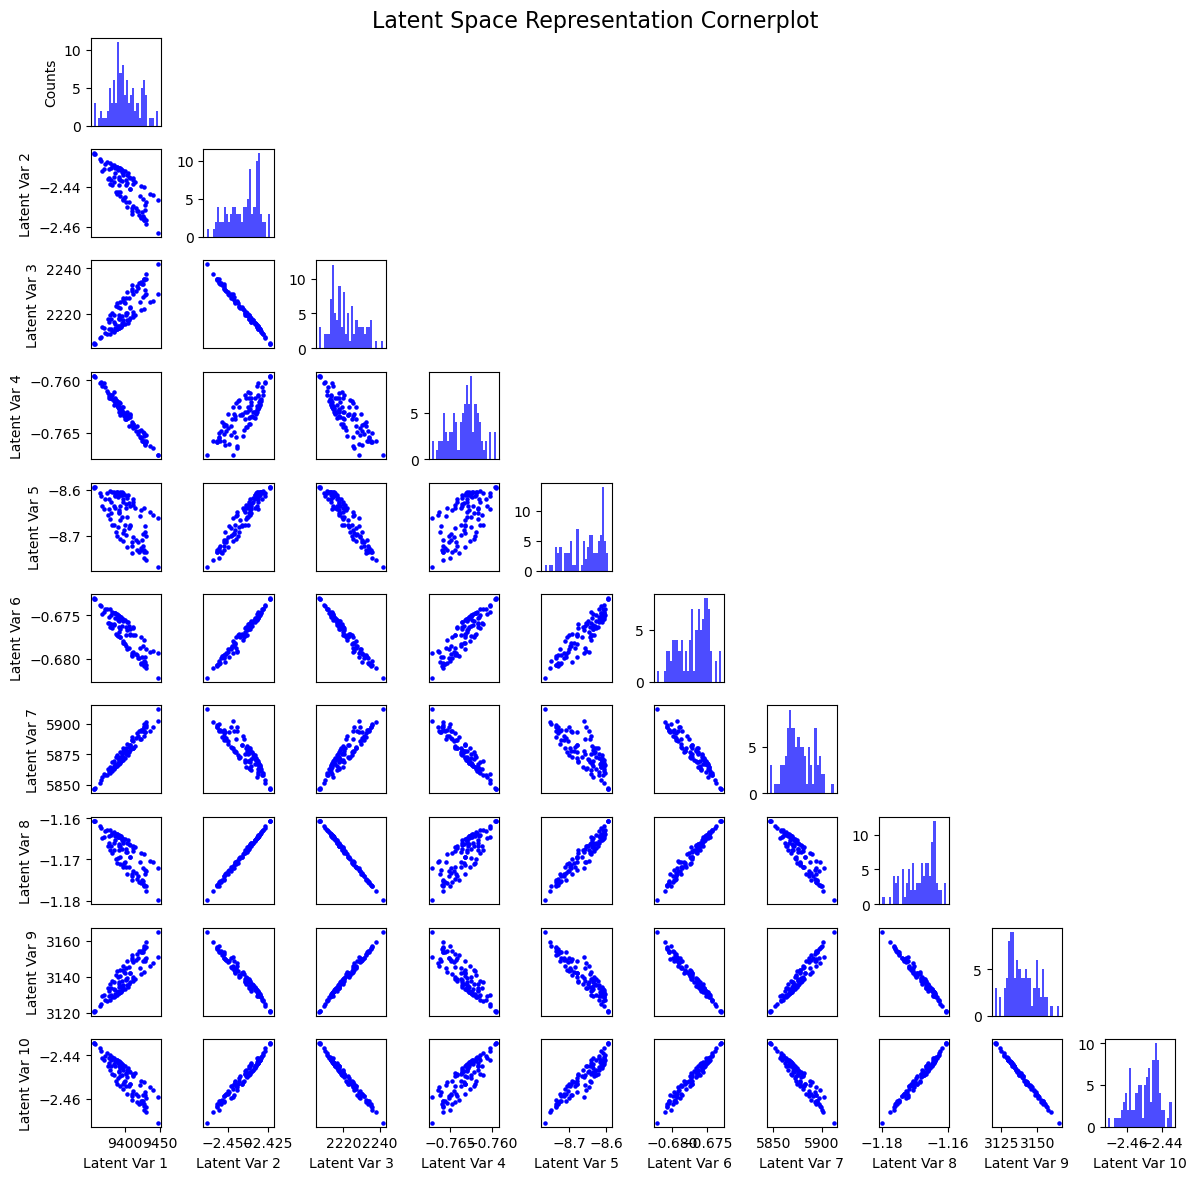

In [197]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Get the number of dimensions in the latent space
num_dimensions = 10

# Create labels for each dimension
labels = [f"Latent Var {i + 1}" for i in range(num_dimensions)]

# Create a square grid of subplots
fig, axes = plt.subplots(num_dimensions, num_dimensions, figsize=(12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Plot histograms on the diagonal
for i in range(num_dimensions):
    axes[i, i].hist(latent_activations[:, i], bins=30, color='blue', alpha=0.7)
    if i == 0:
        axes[i, i].set_ylabel('Counts')
    if i == num_dimensions - 1:
        axes[i, i].set_xlabel(labels[i])
        axes[i, i].tick_params(axis='x', bottom=True, top=False)
    else:
        axes[i, i].tick_params(axis='x', bottom=False, top=False, labelbottom=False)

# Plot scatter plots under the diagonal
for i in range(num_dimensions):
    for j in range(i + 1, num_dimensions):
        axes[j, i].scatter(latent_activations[:, i], latent_activations[:, j], s=5, color='blue')
        axes[i, j].set_axis_off()
        if i == 0:
            axes[j, i].set_ylabel(labels[j])
            axes[j, i].tick_params(axis='y', left=True, right=False)
        else:
            axes[j, i].tick_params(axis='y', left=False, right=False, labelleft=False)

        # Adjust y-axis labels and ticks
        if j == num_dimensions - 1:
            axes[j, i].set_xlabel(labels[i])
            axes[j, i].tick_params(axis='x', bottom=True, top=False)
        else:
            axes[j, i].tick_params(axis='x', bottom=False, top=False, labelbottom=False)

# Put a title 
fig.suptitle('Latent Space Representation Cornerplot', fontsize=16)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()



In [55]:
# Testing the autoencoder
conv_autoencoder.eval()
with torch.no_grad():
    for data, _ in train_loader:
        inputs = data
        reconstructed = conv_autoencoder(inputs)[0]
        break  # Only test one batch for simplicity

# Convert tensors to numpy arrays for plotting
original_np = inputs[0].numpy().reshape((1024, 512))
reconstructed_np = reconstructed[0].numpy().reshape((1024, 512))

# Visualize original and reconstructed data
plot_dynamic_spectra(original_np, title="Original Dynamic Spectra")
plot_dynamic_spectra(reconstructed_np, title="Reconstructed Dynamic Spectra")

NameError: name 'train_loader' is not defined

In [214]:
print("data_train_tensor shape:", data_train_tensor.shape)
print("data_train shape:", data_train.shape)

data_train_tensor shape: torch.Size([400, 1, 1024, 512])
data_train shape: (400, 1024, 512)


## Only a single example

In [7]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


243354624
Model size: 42.001 MB
Epoch [1/100], Train Loss: 0.0045, Val Loss: 0.0043
Epoch [2/100], Train Loss: 0.0045, Val Loss: 0.0043
Epoch [3/100], Train Loss: 0.0045, Val Loss: 0.0043
Epoch [4/100], Train Loss: 0.0045, Val Loss: 0.0043
Epoch [5/100], Train Loss: 0.0045, Val Loss: 0.0043
Epoch [6/100], Train Loss: 0.0045, Val Loss: 0.0043
Epoch [7/100], Train Loss: 0.0045, Val Loss: 0.0043
Epoch [8/100], Train Loss: 0.0045, Val Loss: 0.0043
Epoch [9/100], Train Loss: 0.0045, Val Loss: 0.0043
Epoch [10/100], Train Loss: 0.0045, Val Loss: 0.0043
Epoch [11/100], Train Loss: 0.0044, Val Loss: 0.0040
Epoch [12/100], Train Loss: 0.0040, Val Loss: 0.0036
Epoch [13/100], Train Loss: 0.0036, Val Loss: 0.0032
Epoch [14/100], Train Loss: 0.0032, Val Loss: 0.0028
Epoch [15/100], Train Loss: 0.0028, Val Loss: 0.0025
Epoch [16/100], Train Loss: 0.0026, Val Loss: 0.0023
Epoch [17/100], Train Loss: 0.0023, Val Loss: 0.0020
Epoch [18/100], Train Loss: 0.0020, Val Loss: 0.0018
Epoch [19/100], Train L

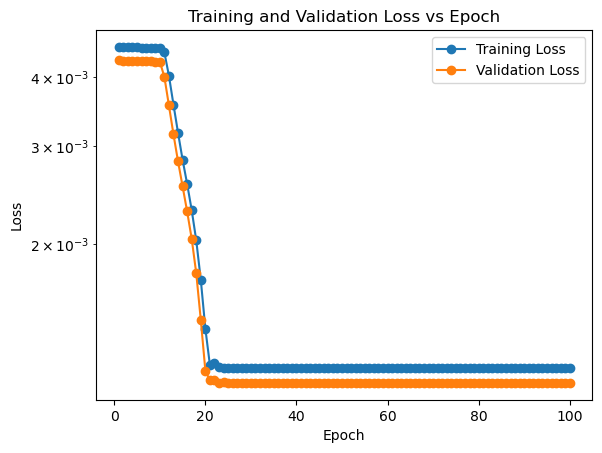

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()

# Define the autoencoder architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),  # 1x1024x512 (no compression)
            nn.LeakyReLU(),
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),  # 1x1024x512 (no compression)
            nn.LeakyReLU(),
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),  # 1x1024x512 (no compression)
            nn.LeakyReLU(),
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),  # 1x1024x512 (no compression)
            nn.LeakyReLU(),
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),  # 1x1024x512 (no compression)
            nn.LeakyReLU(),
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),  # 1x1024x512 (no compression)
            nn.LeakyReLU(),
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),  # 1x1024x512 (no compression)
            nn.LeakyReLU(),
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),  # 1x1024x512 (no compression)
            nn.LeakyReLU(),
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),  # 1x1024x512 (no compression)
            nn.LeakyReLU(),
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),  # 1x1024x512 (no compression)
            nn.LeakyReLU(),
            nn.Flatten(),  # Flatten the output
            nn.Linear(1 * 1024 * 512, 10)  # Projection to 10 latent variables
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 1 * 1024 * 512),  # Reverse projection
            nn.Unflatten(1, (1, 1024, 512)),  # Unflatten to original shape
            nn.ConvTranspose2d(1, 1, kernel_size=3, stride=1, padding=1),  # Reverse convolution
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1, 1, kernel_size=3, stride=1, padding=1),  # Reverse convolution
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1, 1, kernel_size=3, stride=1, padding=1),  # Reverse convolution
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1, 1, kernel_size=3, stride=1, padding=1),  # Reverse convolution
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1, 1, kernel_size=3, stride=1, padding=1),  # Reverse convolution
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1, 1, kernel_size=3, stride=1, padding=1),  # Reverse convolution
            nn.LeakyReLU(),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1, 1, kernel_size=3, stride=1, padding=1),  # Reverse convolution
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1, 1, kernel_size=3, stride=1, padding=1),  # Reverse convolution
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1, 1, kernel_size=3, stride=1, padding=1),  # Reverse convolution
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1, 1, kernel_size=3, stride=1, padding=1),  # Reverse convolution
            nn.LeakyReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        # print("Shape after encoder:", encoded.shape)  # Print shape after encoder
        decoded = self.decoder(encoded)
        # print("Shape after decoder:", decoded.shape)  # Print shape after decoder
        return decoded, encoded

print(torch.cuda.memory_allocated())

# Convert data to PyTorch tensors 
data_train_tensor = torch.Tensor(data_train[:90, None, :])
data_test_tensor = torch.Tensor(data_test[:10, None, :])

# Initialize the autoencoder and move to GPU
conv_autoencoder = ConvAutoencoder().to(device)

param_size = 0
for param in conv_autoencoder.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in conv_autoencoder.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('Model size: {:.3f} MB'.format(size_all_mb))

# Define the loss function and optimizer 

class MaskedMSELoss(nn.Module):
    def __init__(self, threshold):
        super(MaskedMSELoss, self).__init__()
        self.threshold = threshold

    def forward(self, output, target):
        mask = (target > self.threshold).float()  # Create a mask where target values are above the threshold
        masked_output = output * mask  # Apply the mask to the output
        masked_target = target * mask  # Apply the mask to the target
        loss = torch.mean((masked_output - masked_target) ** 2)  # Compute the mean squared error loss
        return loss

threshold = 0.1 # Adjust the threshold as needed
loss_fn = MaskedMSELoss(threshold)
# loss_fn = torch.nn.MSELoss()

optimizer = optim.Adam(conv_autoencoder.parameters(), lr=0.001) # No weight decay to start
# Give points above certain value higher weights ?

# Create datasets and data loaders for training and validation
batch_size = 10  # Adjust as needed
train_dataset = TensorDataset(data_train_tensor, data_train_tensor)
val_dataset = TensorDataset(data_test_tensor, data_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training and validation loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    conv_autoencoder.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, _ = conv_autoencoder(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    conv_autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = conv_autoencoder(inputs)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}')

# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o', linestyle='-')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o', linestyle='-')
plt.title('Training and Validation Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

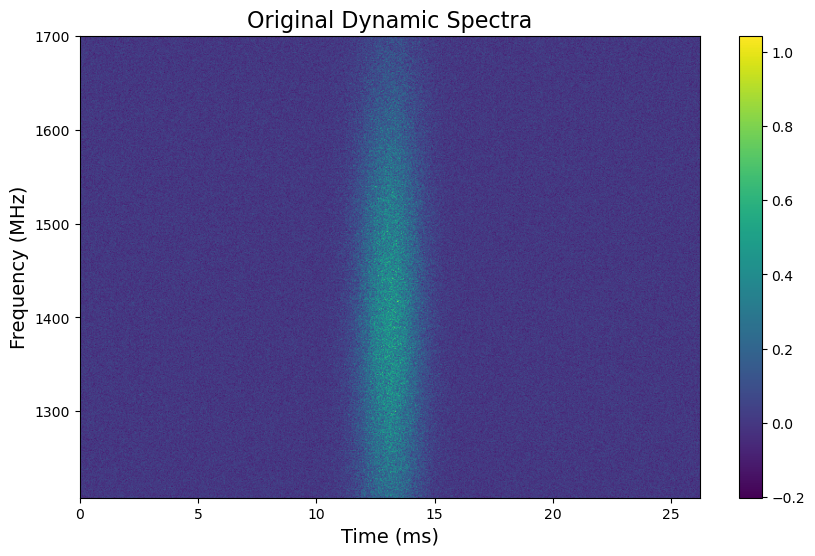

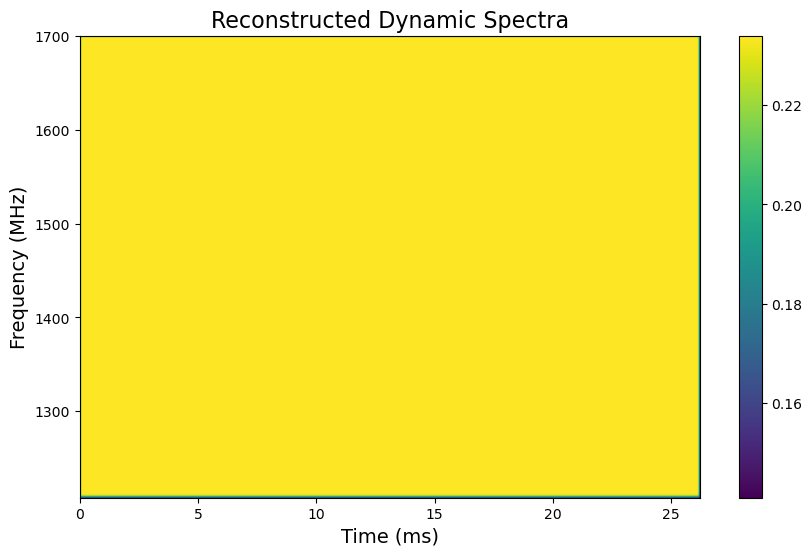

In [34]:
# Select a specific example from the validation set
example_idx = 1
example = data_test_tensor[example_idx:example_idx + 1].to(device)

# Reconstruct the example
with torch.no_grad():
    conv_autoencoder.eval()  # Set the model to evaluation mode
    reconstructed_example, _ = conv_autoencoder(example)

# Convert tensors to numpy arrays for plotting
original_np = example[0, 0].cpu().numpy()
reconstructed_np = reconstructed_example[0, 0].cpu().numpy()

# Visualize original and reconstructed data
plot_dynamic_spectra(original_np, title="Original Dynamic Spectra")
plot_dynamic_spectra(reconstructed_np, title="Reconstructed Dynamic Spectra")
